Shell for the functions needed for the gpt model

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import math
import os
from tqdm.auto import tqdm
import tiktoken
import matplotlib.pyplot as plt
import orbax.checkpoint as ocp
from functools import partial


key = jax.random.PRNGKey(42)

In [2]:
# Hyperparameters
batch_size = 8
context_length = 64
train_test_split_size = 0.9
embed_dim = 16
n_heads = 2
mlp_dim_mul = 4  # between 2 and 8 according to UvA
n_blocks = 2
learning_rate = 3e-4
max_iters = 1000

# Scheduler
scheduler_warmup_steps = 100
scheduler_decay_steps = 500

# Generation
temperature = 1


# Parallelising
devices = jax.local_devices()
print(devices)

# Check if hyperparams make sense
assert embed_dim % n_heads == 0
assert scheduler_decay_steps <= max_iters
assert scheduler_warmup_steps <= scheduler_decay_steps

[CpuDevice(id=0)]


In [3]:
def open_data(path: str = "./new_nietzsche.txt"):
    txt = open(path, "r", encoding="utf-8").read()
    return txt

text = open_data()

In [4]:
class Tokenizer:
    """
    Class that takes care of encoding and decoding the text
    """

    def __init__(self, text: str, tokenizer_type: str = "base") -> None:
        self.tokenizer_type = tokenizer_type

        if self.tokenizer_type == "base":
            self.vocab_size, self.all_characters = self.sort_characters(text)
        elif self.tokenizer_type == "gpt-4o":
            self.enc = tiktoken.encoding_for_model("gpt-4o")
            self.vocab_size = self.enc.n_vocab

    def get_vocab_size(self):
        return int(jnp.copy(self.vocab_size))

    def sort_characters(self, data):
        all_characters = sorted(list(set(data)))
        vocab_size = len(all_characters)

        return vocab_size, all_characters

    def encode(self, text):
        encoded_text = []
        if self.tokenizer_type == "base":
            for c in text:
                num = self.all_characters.index(c)
                encoded_text.append(num)
        elif self.tokenizer_type == "gpt-4o":
            encoded_text = self.enc.encode(text)
        return jnp.array(encoded_text)

    def decode(self, encoded_text):
        text = []
        if self.tokenizer_type == "base":
            for n in encoded_text:
                char = self.all_characters[n]
                text.append(char)
            text = "".join([str(item) for item in text])

        elif self.tokenizer_type == "gpt-4o":
            text = self.enc.decode(encoded_text)

        return text

In [5]:
tokenizer = Tokenizer(text=text, tokenizer_type="gpt-4o") 
all_data = tokenizer.encode(text)
tokenizer.get_vocab_size()

200019

In [6]:
# test tokenizer
print(tokenizer.decode(all_data[:100]))

What I am now going to relate is the history of the next two centuries.
I shall describe what will happen, what must necessarily happen:
the triumph of Nihilism. This history can be written already; for
necessity itself is at work in bringing it about. This future is
already proclaimed by a hundred different omens; as a destiny it
announces its advent everywhere, for this music of to-morrow all ears
are already pricked. The whole of our culture


In [7]:
class BatchLoader:
    def __init__(self, data, train_test_split_size, key) -> None:
        self.training_data, self.validation_data = self.splitting_data(
            data, train_test_split_size
        )
        self.key = key

    def splitting_data(self, data, split_size):
        n = int(split_size * len(data))
        training_data = data[:n]
        validation_data = data[n:]
        return training_data, validation_data

    def get_batch(self, batch_size, context_length, training: bool = True):
        train_batches = []
        target_batches = []

        if training:
            b_data = self.training_data
        else:
            b_data = self.validation_data

        for _ in range(batch_size):
            self.key, subkey = jax.random.split(self.key)
            pos = jax.random.randint(
                key=subkey, shape=(), minval=0, maxval=(len(b_data) - context_length)
            )
            batch_data = b_data[pos : pos + context_length]
            train_batches.append(batch_data)
            batch_data = b_data[pos + 1 : pos + context_length + 1]
            target_batches.append(batch_data)

        train_batches = jnp.stack(train_batches)
        target_batches = jnp.stack(target_batches)

        return train_batches, target_batches

In [8]:
batch_loader = BatchLoader(data=all_data, train_test_split_size=train_test_split_size, key=key)
train, targets = batch_loader.get_batch(batch_size, context_length, training=True)
print(train.shape)
print(targets.shape)

(8, 64)
(8, 64)


In [9]:
class SingleAttentionHead(nn.Module):
    embed_dim: int
    head_size: int

    def setup(self):
        self.key = nn.Dense(self.head_size, use_bias=False) 
        self.query = nn.Dense(self.head_size, use_bias=False)
        self.value = nn.Dense(self.head_size, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        
        k = self.key(data)  # from embed_dim to head_size (B,T,C)
        q = self.query(data) # from embed_size to head_size (B,T,C)
        v = self.value(data) # from embed_size to head_size (B,T,C)

        weights = jnp.matmul(q,jnp.swapaxes(k, -2,-1)) / math.sqrt(self.head_size) # (B,T,T)
        
        #Lower triangular mask matrix of the size B, T, C (same btw as attention)
        mask = jnp.tril(weights)
        
        # for every zero, make it to -inf 
        weights = nn.softmax(jnp.where(mask == 0, -9e16, weights), axis=-1) # axis=-1 since we only want to softmax for each row of T not for the whole data as a whole
        
        weights = self.dropout(weights, deterministic = not training)

        attention = jnp.matmul(weights, v) # (B,T,C)

        return attention

In [10]:
class MultiHeadAttention(nn.Module):
    """
    Multiple attention heads combined together
    """

    head_num: int
    embed_dim: int

    def setup(self):
        self.heads = [
            SingleAttentionHead(
                embed_dim=self.embed_dim, head_size=self.embed_dim // self.head_num
            )
            for _ in range(self.head_num)
        ]
        self.think = nn.Dense(self.embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        multiple_attentions = jnp.concatenate(
            [head(data, training) for head in self.heads], axis=-1
        )
        thoughts = self.think(multiple_attentions)
        out = self.dropout(thoughts, deterministic = not training)
        return out

In [11]:
class FeedForward(nn.Module):
    '''Simple Feed Forward NN that goes from embed_dim to a higher dimension and then back to embed_dim'''
    
    embed_dim: int
    dim_mul: int

    def setup(self):
        #this is the heavy thinking part of the model, where it tries to make sense of what was learned
        # in the attention cycle lol
        self.layer1 = nn.Dense(features=(self.dim_mul*embed_dim), use_bias=False)
        self.layer2 = nn.Dense(features=embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training: bool):
        x = data
        x = self.layer1(x)
        x = nn.relu(x)
        x = self.layer2(x)
        x = self.dropout(x, deterministic = not training)
        return x

In [12]:
class Block(nn.Module):
    '''One run through a block, which consists of MultiheadAttention + Feedforward + Layer Normalisation'''
    dim_mul: int
    embed_dim: int
    head_num: int
    
    def setup(self):
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.multihead = MultiHeadAttention(head_num = self.head_num, embed_dim=self.embed_dim)
        self.feedforward = FeedForward(embed_dim=self.embed_dim, dim_mul=self.dim_mul)
    
    def __call__(self, data, training: bool):
        x = data
        x = x + self.multihead(self.norm1(x), training)
        x = x + self.feedforward(self.norm2(x), training)

        return x

In [13]:
class CustomSequential(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x, *args, **kwargs):
        for layer in self.layers:
            x = layer(x, *args, **kwargs)
        return x

In [14]:
class TransformerModel(nn.Module):
    vocab_size: int
    context_length: int
    embed_dim: int
    head_num: int
    dim_mul: int
    n_blocks: int

    def setup(self):
        self.token_embedding_table = nn.Embed(self.vocab_size, self.embed_dim)
        self.position_embedding_table = nn.Embed(self.context_length, self.embed_dim)
        #########################
        self.blocks = CustomSequential(
            [
                Block(
                    head_num=self.head_num,
                    embed_dim=self.embed_dim,
                    dim_mul=self.dim_mul,
                )
                for _ in range(self.n_blocks)
            ]
        )

        #########################
        self.norm = nn.LayerNorm()
        self.linear = nn.Dense(self.vocab_size, use_bias=False)

    def __call__(self, data, training: bool = True):
        _, context_length = data.shape

        token = self.token_embedding_table(data)
        position = self.position_embedding_table(jnp.arange(context_length))

        embedded_data = token + position

        iteration_data = self.blocks(
            embedded_data, training
        )  # data after one iteration MH,FF (4,8,32)
        data_normalized = self.norm(iteration_data)
        final_data = self.linear(data_normalized)

        return final_data

In [15]:
# Optimizer
scheduler = optax.warmup_cosine_decay_schedule(
    init_value=0.01,
    peak_value=1,
    warmup_steps=scheduler_warmup_steps,
    decay_steps=scheduler_decay_steps,
)
optimizer = optax.adamw(scheduler)

In [16]:
# Model init
data = jnp.ones(
    (batch_size, context_length), dtype=jnp.int32
)
# labels = jnp.ones((batch_size, context_length), dtype=jnp.int32)

model = TransformerModel(
    vocab_size=tokenizer.get_vocab_size(),
    context_length=context_length,
    embed_dim=embed_dim,
    head_num=n_heads,
    dim_mul=mlp_dim_mul,
    n_blocks=n_blocks,
)

# specify what the key is used
key, param_key, dropout_key = jax.random.split(key, num=3)
variables = model.init(param_key, data=data, training=False)

In [17]:
# Training State
params = variables["params"]

class TrainState(train_state.TrainState):
    key: jax.Array

state = TrainState.create(
    apply_fn=model.apply, params=params, key=dropout_key, tx=optimizer
)

In [18]:
# Checkpoints
from flax.training import orbax_utils

current_directory = os.getcwd()
dir_path = os.path.join(current_directory, "checkpoints")

if not os.path.exists(dir_path):
    os.mkdir(dir_path)

ckpt = {"model": state}
orbax_checkpointer = ocp.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)

path = ocp.test_utils.erase_and_create_empty(dir_path)
options = ocp.CheckpointManagerOptions(max_to_keep=3)
checkpoint_manager = ocp.CheckpointManager(path, orbax_checkpointer, options)

In [19]:
@partial(jax.pmap, axis_name="batch")
@jax.jit  # Jit the function for efficiency
def _train_step(state, batch, dropout_key):
    dropout_key, dropout_train_key = jax.random.split(dropout_key)

    def loss_fn(params):
        data, labels = batch

        # Same as model.apply
        logits = state.apply_fn(
            {"params": params}, data, training=True, rngs={"dropout": dropout_train_key}
        )

        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
        mean_loss = jnp.mean(loss)

        return mean_loss, logits

    # Gradient function
    grad_fn = jax.value_and_grad(
        loss_fn,  # Function to calculate the loss
        has_aux=True,  # Function has additional outputs, here accuracy
    )
    # Determine gradients for current model, parameters and batch
    (loss, logits), grads = grad_fn(state.params)

    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss


@partial(jax.pmap, axis_name="batch")
@jax.jit  # Jit the function for efficiency
def _eval_step(state, batch):
    data, labels = batch
    logits = state.apply_fn({"params": state.params}, data, training=False)

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    mean_loss = jnp.mean(loss)

    return mean_loss


def train(state, num_epochs, dropout_key):
    replicated_state = jax.device_put_replicated(state, jax.local_devices())
    train_losses = []
    eval_losses = []
    best_eval_loss = float('inf')

    for epoch in tqdm(range(num_epochs + 1)):
        # Get data
        train, train_labels = batch_loader.get_batch(
            batch_size, context_length, training=True
        )

        # Reshaping to be compatiple with pmap
        dropout_keys = jax.random.split(dropout_key, jax.local_device_count())
        train = train.reshape((jax.local_device_count(), -1, *train.shape[1:]))
        train_labels = train_labels.reshape(
            (jax.local_device_count(), -1, *train_labels.shape[1:])
        )

        # Train step
        train_batch = (train, train_labels)
        replicated_state, gpu_train_losses = _train_step(
            replicated_state, train_batch, dropout_keys
        )
        print(gpu_train_losses)

        # Get mean loss across gpus
        train_loss = jnp.mean(gpu_train_losses)

        if epoch % 100 == 0:
            # Get data
            eval, eval_labels = batch_loader.get_batch(
                batch_size, context_length, training=False
            )

            # Reshaping to be compatiple with pmap
            eval = eval.reshape((jax.local_device_count(), -1, *eval.shape[1:]))
            eval_labels = eval_labels.reshape(
                (jax.local_device_count(), -1, *eval_labels.shape[1:])
            )

            # Eval step
            eval_batch = (eval, eval_labels)
            gpu_eval_losses = _eval_step(replicated_state, eval_batch)

            # Get mean loss across gpus
            eval_loss = jnp.mean(gpu_eval_losses)

            # Saving best model according to loss
            if eval_loss < best_eval_loss:
                print(f"Saved model with loss {eval_loss}")
                checkpoint_manager.save(
                    epoch,
                    ckpt,
                    save_kwargs={"save_args": save_args},
                )
                checkpoint_manager.wait_until_finished()
                best_eval_loss = eval_loss

            # Appending losses
            train_losses.append(train_loss)
            eval_losses.append(eval_loss)

            print(f"Epoch {epoch}: Train loss {train_loss}, Eval loss {eval_loss}")

    return replicated_state, train_losses, eval_losses


def plot_loss_curves(train_losses, eval_losses, eval_interval=100):
    epochs = range(len(train_losses))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, eval_losses, label="Evaluation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Curves")
    plt.legend()
    plt.show()

  0%|          | 0/1001 [00:00<?, ?it/s]

[12.831674]
Saved model with loss 12.602885246276855
Epoch 0: Train loss 12.831673622131348, Eval loss 12.602885246276855
[12.560215]
[12.337711]
[11.971147]
[11.420347]
[10.530421]
[9.808333]
[9.094787]
[8.53267]
[9.579657]
[9.121687]
[8.6487465]
[8.98131]
[8.647947]
[8.312853]
[8.092354]
[8.34677]
[8.670789]
[8.452587]
[8.228092]
[8.535551]
[8.083835]
[8.629621]
[7.8098154]
[7.728613]
[8.135667]
[8.131397]
[8.564862]
[8.63665]
[9.016318]
[8.466871]
[8.539921]
[8.197928]
[8.457073]
[8.081003]
[8.040634]
[7.804453]
[7.8391027]
[8.941538]
[7.966301]
[10.293512]
[10.243787]
[10.7834215]
[8.886599]
[8.374202]
[10.430328]
[11.61274]
[10.708284]
[10.720238]
[10.655449]
[9.767897]
[9.282543]
[9.416098]
[8.292217]
[8.375568]
[8.911699]
[8.129272]
[8.970819]
[8.278587]
[8.290073]
[9.012926]
[8.650267]
[8.6069355]
[8.927007]
[9.151262]
[9.767799]
[9.605539]
[10.090736]
[12.691555]
[11.4759865]
[17.71939]
[12.306366]
[12.051865]
[11.429914]
[10.232464]
[13.89311]
[15.684008]
[16.86168]
[15.48140

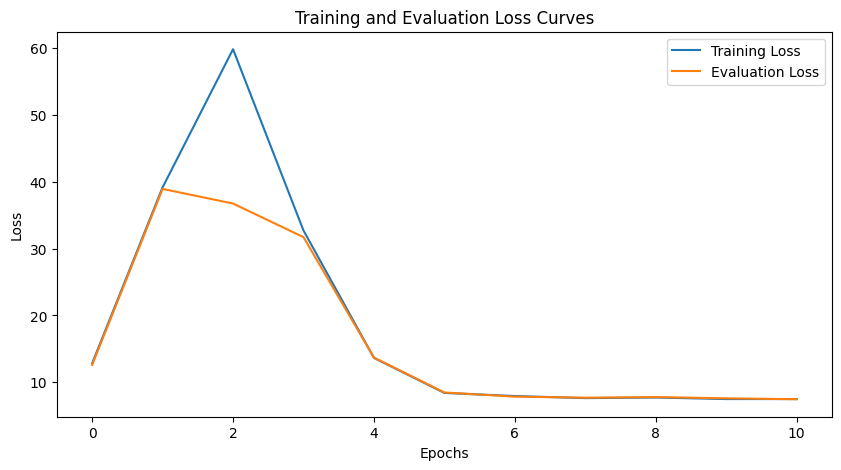

In [20]:
# Training

trained_model_state, train_losses, eval_losses = train(
    state=state, num_epochs=max_iters, dropout_key=dropout_key
)
plot_loss_curves(train_losses, eval_losses)

In [21]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4))
def generate(state, key, data, length, temperature):
    params = state.params
    for _ in range(length):
        key, subkey = jax.random.split(key)  # Every character has to be different
        data_to_use = data[:, -context_length:]

        logits = state.apply_fn({"params": params}, data_to_use, training=False)
        logits = logits[:, -1, :]

        next_token = jax.random.categorical(subkey, logits / temperature, shape=(1, 1))

        data = jnp.concatenate((data, next_token), axis=1)

    return data[0]

In [22]:
# Generation
generate_keys = jax.random.split(key, jax.local_device_count())
data = jnp.ones((jax.device_count(), 1, 1), dtype=jax.numpy.int32) # device_count, 1, 1
generated_seq = generate(
    trained_model_state,
    generate_keys,
    data,
    50,
    temperature,
)

print(generated_seq)
decoded_text = tokenizer.decode(generated_seq[0])

print(decoded_text)

[[     1    198    673    198    842   1386    395   1293  30507  47329
    5299    493     40 162813  21779    558  51800    334   4271   3901
     258   6062    326  22773 109814   5151    316    484   3324  24140
    2226 134186     25   1039   1058   4561    860   2345  33972    375
   30664 107314    290  86839    392  76937    656   4525   2452      1
    8175]]
"
 was
 outices forread impressed untoHowantIunderland fur.
 Luther de enjoy?
in whole and combat khoản above to that always existence doesscience: our time live nobysan-- happiness tedious the priests "ুলো by thought made"tempt
